In [6]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import torch
from surprise import Dataset, Reader, SVD, KNNBasic, accuracy

# Setup

In [7]:
DATA_DIR = "D:\\Delft\\ml-100k\\"
ratings = pd.read_csv(f"{DATA_DIR}u.data", sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])

# Get average ratings of user, could be interesting


In [8]:
user_ratings = ratings.groupby('user_id')['rating'].mean().reset_index()
print(user_ratings)

users_rated = ratings['user_id'].value_counts().mean()
print(f"Average movies rated by a user: {users_rated} ")

     user_id    rating
0          1  3.610294
1          2  3.709677
2          3  2.796296
3          4  4.333333
4          5  2.874286
..       ...       ...
938      939  4.265306
939      940  3.457944
940      941  4.045455
941      942  4.265823
942      943  3.410714

[943 rows x 2 columns]
Average movies rated by a user: 106.04453870625663 


# Get 62 users with 100-120 ratings

In [9]:
users_ratings = ratings['user_id'].value_counts()
filtered_users = users_ratings[(users_ratings >= 100) & (users_ratings <= 200)].index

user_ratings = ratings[ratings['user_id'].isin(filtered_users)]
print(f"Total ratings: {len(user_ratings)}")

Total ratings: 30600


# Get results with full set (for metrics lower is better)

In [10]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split


reader = Reader(rating_scale=(1, 5))
trainset_global, testset_global = train_test_split(Dataset.load_from_df(user_ratings[["user_id", "movie_id", "rating"]], reader), test_size=0.2)
print(trainset_global.n_items)
algo = SVD()
algo.fit(trainset_global)
predictions = algo.test(testset_global)

accuracy.rmse(predictions)
accuracy.mae(predictions)

1351
RMSE: 0.9671
MAE:  0.7679


0.767867885555174

# Remove fraction of ratings + plots

In [11]:
from surprise import BaselineOnly
original_ratings = user_ratings.copy()

reader = Reader(rating_scale=(1, 5))
fractions = [0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]

test_users = set([uid for (uid, _, _) in testset_global])
test_items = set([iid for (_, iid, _) in testset_global])

data = Dataset.load_from_df(user_ratings[['user_id', 'movie_id', 'rating']], reader)


results = []
results_b = []
for frac in fractions:
    if frac > 0:
        reduced_data_frame = original_ratings.sample(frac=(1-frac), random_state=42)
    else:
        reduced_data_frame = original_ratings.copy()


    train_df = reduced_data_frame[~reduced_data_frame.apply(lambda row: (row['user_id'], row['movie_id']) in
                                        [(uid, iid) for (uid, iid, _) in testset_global], axis=1)]

    reduced_data = Dataset.load_from_df(train_df[['user_id', 'movie_id', 'rating']], reader)
    trainset = reduced_data.build_full_trainset()

    algo = SVD()
    algo_b = BaselineOnly()


    algo.fit(trainset)
    algo_b.fit(trainset)

    predictions = algo.test(testset_global)
    predictions_b = algo.test(testset_global)

    rmse = accuracy.rmse(predictions, verbose=False)
    rmse_b = accuracy.rmse(predictions_b, verbose=False)

    mae = accuracy.mae(predictions, verbose=False)
    mae_b = accuracy.mae(predictions_b, verbose=False)

    results.append((1 - frac, rmse, mae))
    results_b.append((1 - frac, rmse_b, mae_b))

    print(f"Kept {int((1-frac)*100)}% of ratings → RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    print(f"Kept baseline {int((1-frac)*100)}% of ratings → RMSE: {rmse_b:.4f}, MAE: {mae_b:.4f}")


Estimating biases using als...
Kept 100% of ratings → RMSE: 0.9685, MAE: 0.7684
Kept baseline 100% of ratings → RMSE: 0.9685, MAE: 0.7684
Estimating biases using als...
Kept 90% of ratings → RMSE: 0.9691, MAE: 0.7693
Kept baseline 90% of ratings → RMSE: 0.9691, MAE: 0.7693
Estimating biases using als...
Kept 80% of ratings → RMSE: 0.9707, MAE: 0.7702
Kept baseline 80% of ratings → RMSE: 0.9707, MAE: 0.7702
Estimating biases using als...
Kept 70% of ratings → RMSE: 0.9725, MAE: 0.7712
Kept baseline 70% of ratings → RMSE: 0.9725, MAE: 0.7712
Estimating biases using als...
Kept 50% of ratings → RMSE: 0.9856, MAE: 0.7840
Kept baseline 50% of ratings → RMSE: 0.9856, MAE: 0.7840
Estimating biases using als...
Kept 30% of ratings → RMSE: 0.9931, MAE: 0.7904
Kept baseline 30% of ratings → RMSE: 0.9931, MAE: 0.7904
Estimating biases using als...
Kept 9% of ratings → RMSE: 1.0378, MAE: 0.8321
Kept baseline 9% of ratings → RMSE: 1.0378, MAE: 0.8321


# Plot results

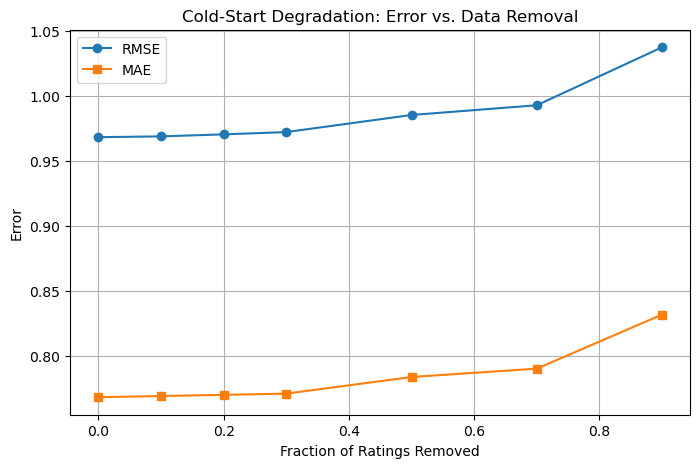

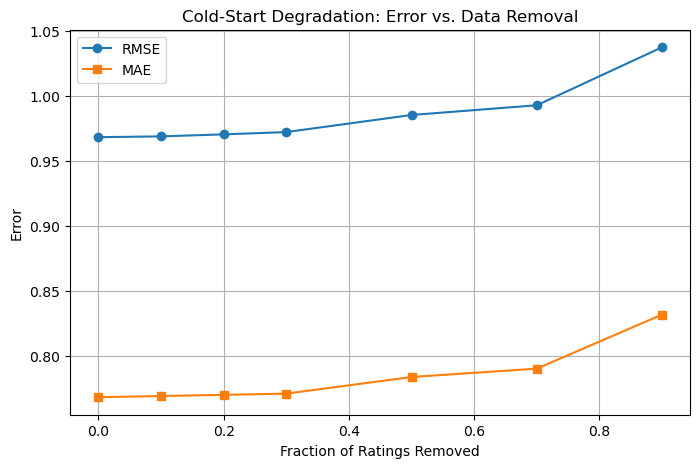

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

fractions_kept, rmses, maes = zip(*results)
fractions_removed = [1 - f for f in fractions_kept]  # fraction removed

fig = plt.figure(figsize=(8, 5))
plt.plot(fractions_removed, rmses, label='RMSE', marker='o')
plt.plot(fractions_removed, maes, label='MAE', marker='s')
plt.xlabel("Fraction of Ratings Removed")
plt.ylabel("Error")
plt.title("Cold-Start Degradation: Error vs. Data Removal")
plt.grid(True)
plt.legend()
fig